In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc
import anndata as ad
import scmulti
from random import shuffle
from scipy import sparse
from matplotlib import pyplot as plt

In [4]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [5]:
scrna = sc.read_h5ad('../data/kotliarov-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 53196 × 3999
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'hvg', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
cite = sc.read_h5ad('../data/kotliarov-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 53196 × 87
    obs: 'n_genes', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Clean the data

In [7]:
# use more general annotation
# can change to cluster_level2 or cluster_level3 if needed (finer annotation)
scrna.obs['cell_type'] = scrna.obs['cluster_level1'].astype(str)
cite.obs['cell_type'] = cite.obs['cluster_level1'].astype(str)

# Paired setting

## Configure and train the model

In [9]:
# paired
model = scmulti.models.MultiVAE(
    adatas=[[scrna], [cite]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    pair_groups=[[0], [0]],
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [10]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
)

 |██------------------| 10.0% iter=1001/10000, time=460.81(s), loss=0.3907, recon=0.3401, kl=30.9303, integ=5.0263, val_loss=80.2818, val_recon=0.1824, val_kl=41.4280, val_integ=3.0891
 |████----------------| 20.0% iter=2001/10000, time=470.20(s), loss=0.2402, recon=0.2129, kl=59.9927, integ=2.6602, val_loss=65.0304, val_recon=0.1572, val_kl=64.5558, val_integ=1.5318
 |██████--------------| 30.0% iter=3001/10000, time=430.10(s), loss=0.2111, recon=0.1942, kl=78.7656, integ=1.6105, val_loss=58.9956, val_recon=0.1481, val_kl=79.7569, val_integ=0.8225
 |████████------------| 40.0% iter=4001/10000, time=422.13(s), loss=0.2053, recon=0.1935, kl=88.5317, integ=1.0931, val_loss=54.2656, val_recon=0.1393, val_kl=89.4492, val_integ=0.4357
 |██████████----------| 50.0% iter=5001/10000, time=663.54(s), loss=0.1947, recon=0.1867, kl=99.1970, integ=0.6963, val_loss=51.9808, val_recon=0.1351, val_kl=100.5135, val_integ=0.2376
 |████████████--------| 60.0% iter=6001/10000, time=570.16(s), loss=0.1810

## Plot training history

In [11]:
model.history

iteration  train_loss  train_recon    train_kl  train_integ   val_loss  \
0       1000    0.390659     0.340087   30.930271     5.026264  80.281829   
1       2000    0.240151     0.212949   59.992690     2.660182  65.030353   
2       3000    0.211138     0.194245   78.765617     1.610549  58.995598   
3       4000    0.205334     0.193518   88.531709     1.093067  54.265594   
4       5000    0.194704     0.186749   99.197021     0.696252  51.980829   
5       6000    0.181032     0.174786  108.119604     0.516527  51.286012   
6       7000    0.184126     0.179054  119.827623     0.387434  49.996688   
7       8000    0.185388     0.180735  130.950610     0.334336  49.186186   
8       9000    0.173133     0.169042  133.093799     0.275959  49.185492   
9       9999    0.176941     0.173096  140.569388     0.243900  48.994102   

   val_recon      val_kl  val_integ  
0   0.182445   41.428042   3.089103  
1   0.157166   64.555767   1.531834  
2   0.148081   79.756947   0.822536  
3   0.139271   89.449214   0.435724  
4   0.135073  100.513549   0.237585  
5   0.133927  110.429719   0.158548  
6   0.130822  119.708121   0.117306  
7   0.128776  128.932295   0.097218  
8   0.128786  135.951748   0.090256  
9   0.128281  143.191391   0.081498

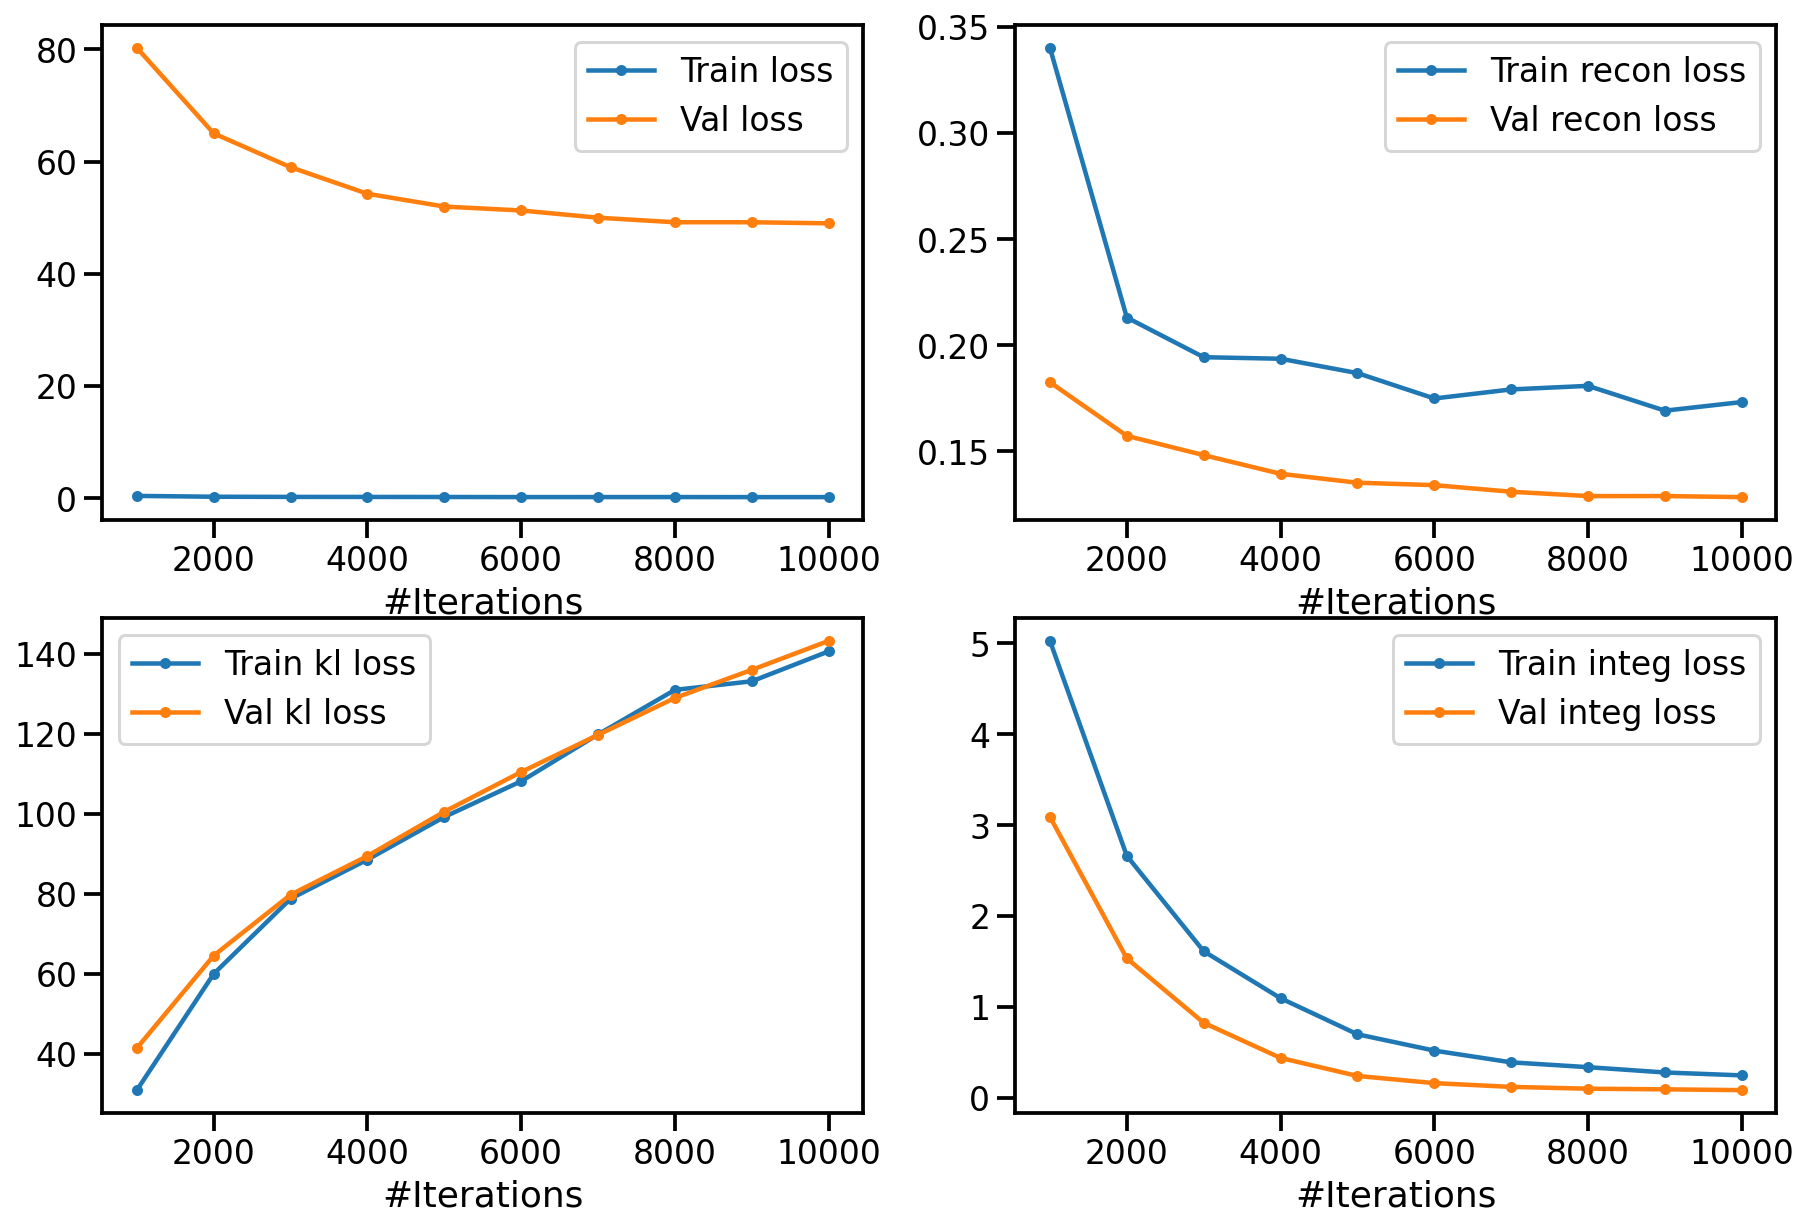

In [14]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Recover and visualize the latent space

In [15]:
z = model.predict(
    adatas=[[scrna], [cite]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 106392 × 20
    obs: 'modality', 'cell_type', 'batch'

In [16]:
sc.tl.pca(z, svd_solver='arpack')

... storing 'modality' as categorical
... storing 'cell_type' as categorical


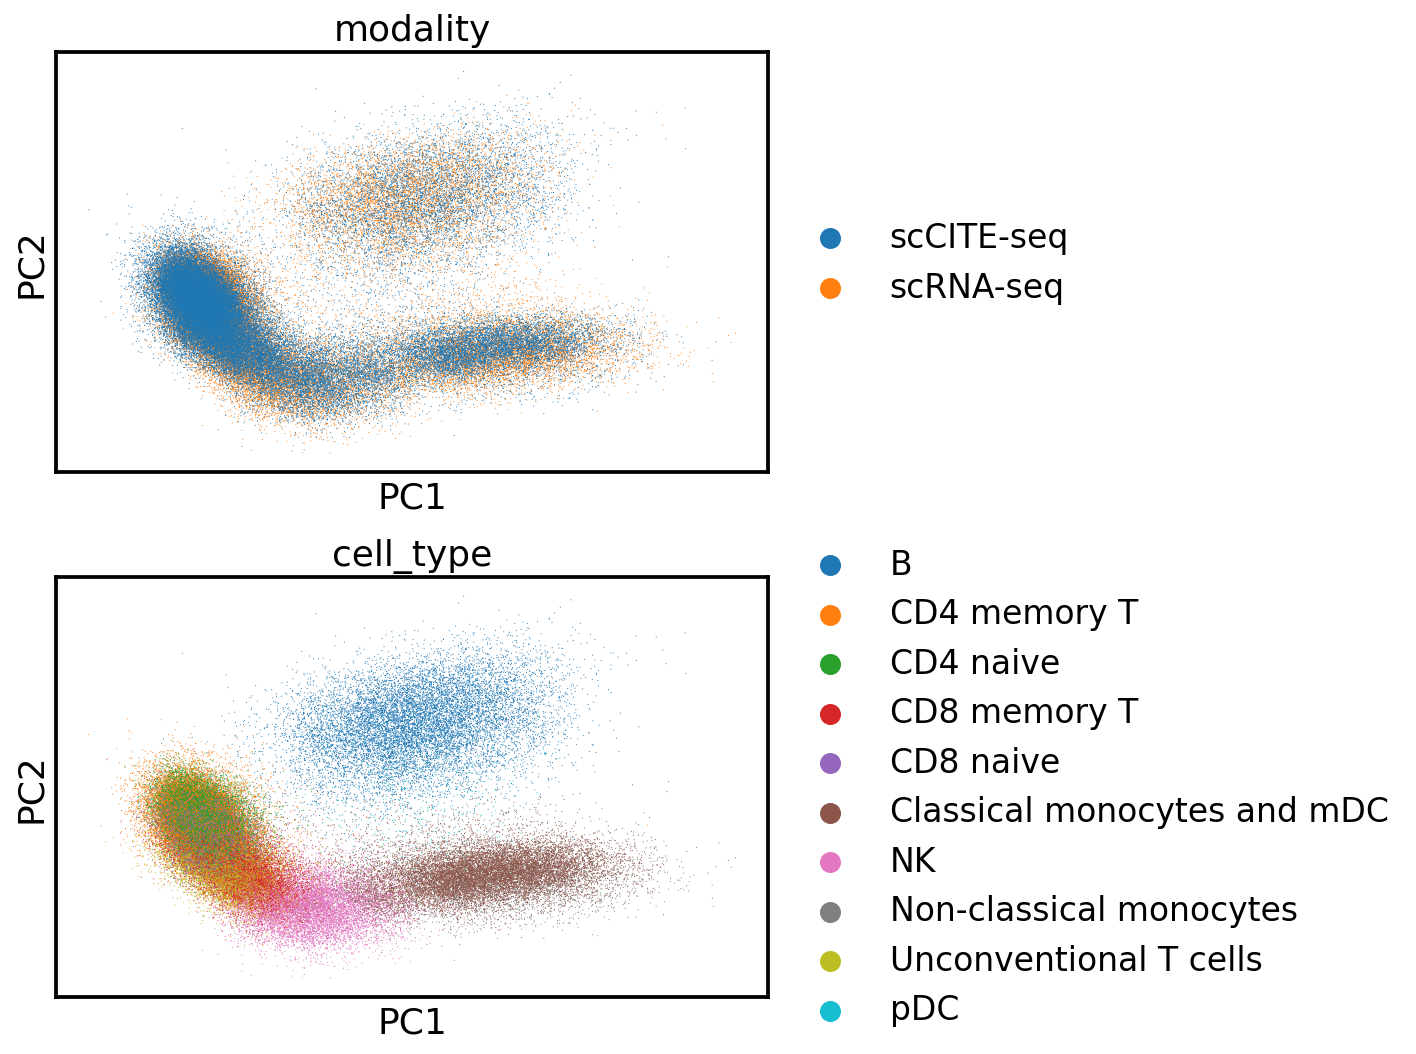

In [17]:
sc.pl.pca(z, color=['modality', 'cell_type'], ncols = 1)

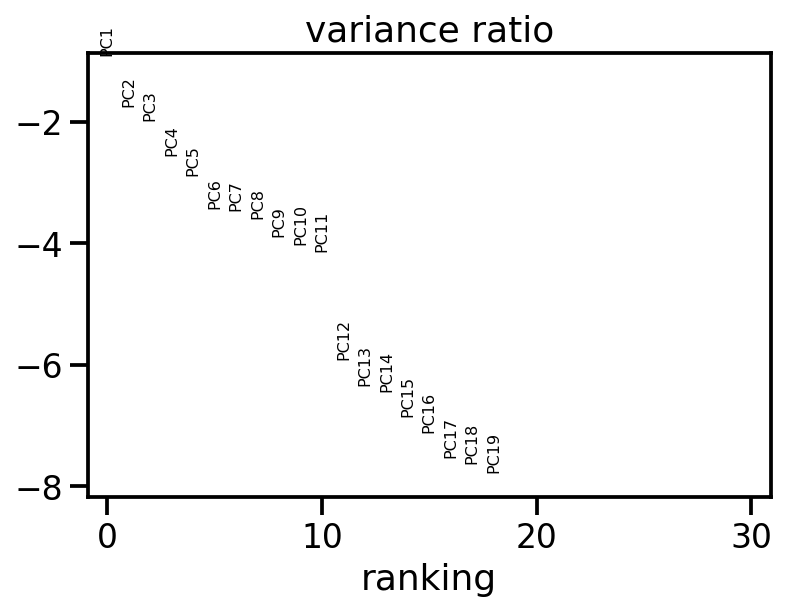

In [18]:
sc.pl.pca_variance_ratio(z, log=True)

In [19]:
# use smaller number of neighbours than the default to make it run faster
sc.pp.neighbors(z, n_neighbors=10, n_pcs=12)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [20]:
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


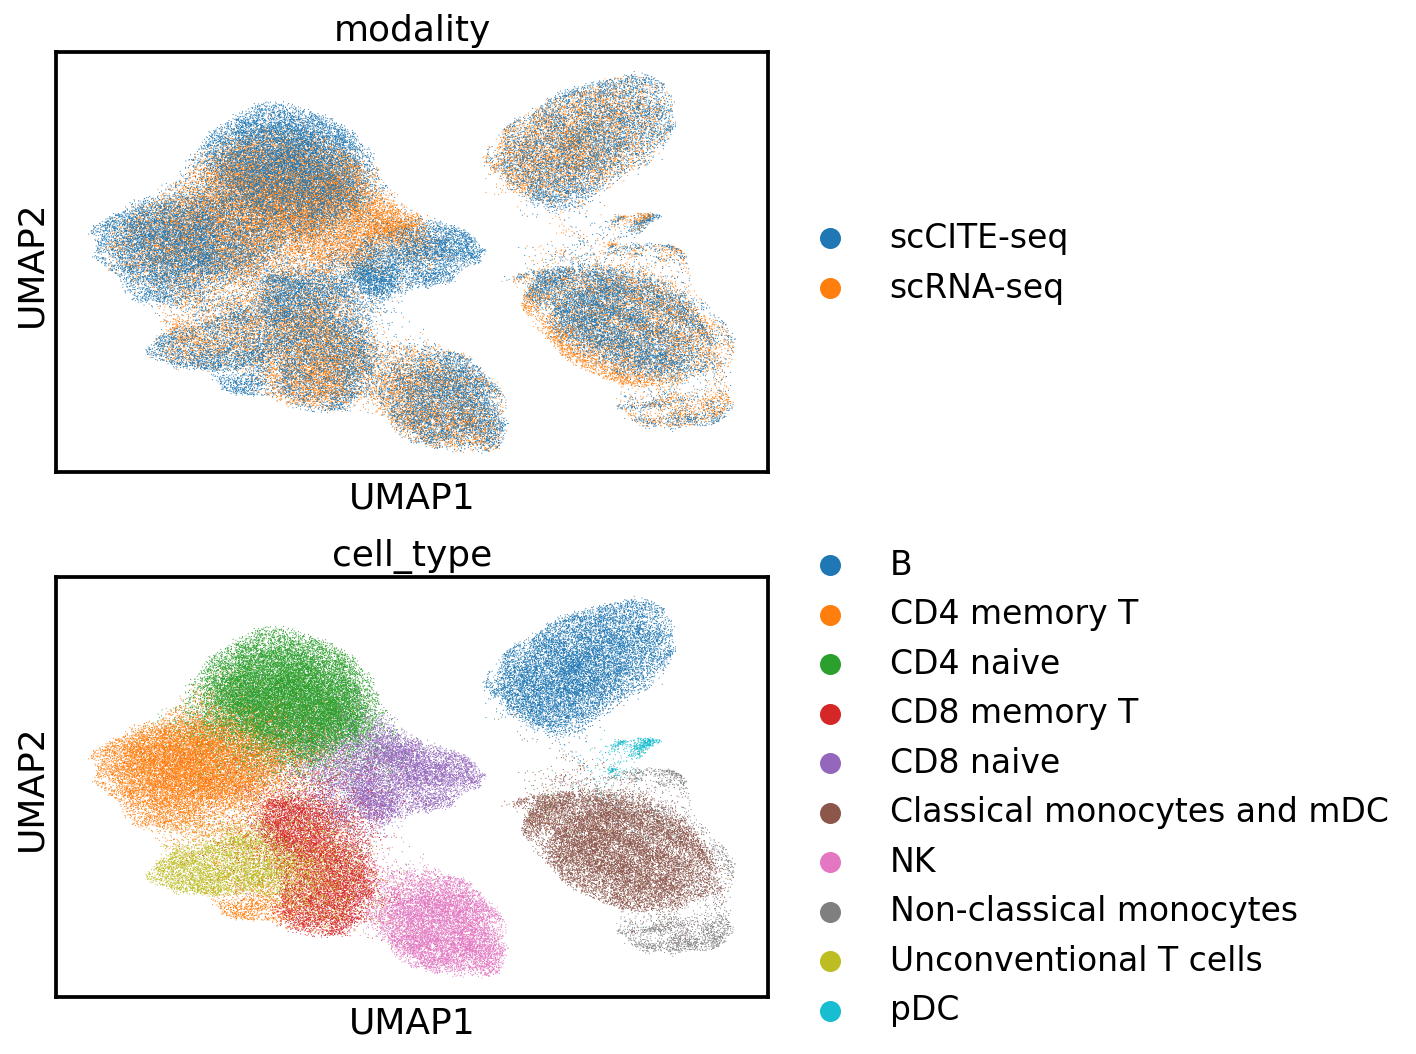

In [21]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

## Metrics

In [22]:
scmulti.metrics.nmi(z, label_key='modality')

8.189348660463816e-05

In [23]:
scmulti.metrics.asw(z, label_key='modality')

0.0038353214040398598

In [24]:
scmulti.metrics.asw(z, label_key='cell_type')

0.2024679034948349

In [6]:
metrics = scmulti.metrics.scibmetrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics

clustering...


/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt

NMI...
ARI...
silhouette score...


0
NMI_cluster/label          0.628787
ARI_cluster/label          0.400657
ASW_label                  0.590996
ASW_label/batch            0.936893
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN

# Unpaired setting

## Shuffle

In [8]:
def shuffle_adata(adata):
    
    mapIndexPosition = list(zip(list(adata.obs_names), range(len(adata.obs_names))))
    shuffle(mapIndexPosition)
    obs_names, idx = zip(*mapIndexPosition)
    
    if sparse.issparse(adata.X):        
        x = adata.X.A[idx, :]
    else:
        x = adata.X[idx, :]
        
    adata.obs_names = adata.obs_names.astype(str).str.strip()
    adata.obs.loc[list(obs_names), :]
    
    return ad.AnnData(x, obs=adata.obs.loc[list(obs_names), :])

In [9]:
scrna_shuffled = shuffle_adata(scrna)
cite_shuffled = shuffle_adata(cite)

## Configure and train the model

In [10]:
# unpaired
model = scmulti.models.MultiVAE(
    adatas=[[scrna_shuffled], [cite_shuffled]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    pair_groups=[[0], [1]],
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [11]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
)

 |██------------------| 10.0% iter=1001/10000, time=267.94(s), loss=0.3244, recon=0.3226, kl=38.1604, integ=0.1446, val_loss=72.0570, val_recon=0.1900, val_kl=50.8852, val_integ=0.1406
 |████----------------| 20.0% iter=2001/10000, time=266.86(s), loss=0.2155, recon=0.2137, kl=80.4455, integ=0.0992, val_loss=60.0219, val_recon=0.1580, val_kl=85.6844, val_integ=0.1087
 |██████--------------| 30.0% iter=3001/10000, time=263.78(s), loss=0.1941, recon=0.1922, kl=110.0150, integ=0.0758, val_loss=57.7157, val_recon=0.1518, val_kl=103.7922, val_integ=0.0912
 |████████------------| 40.0% iter=4001/10000, time=261.59(s), loss=0.1821, recon=0.1801, kl=131.6163, integ=0.0685, val_loss=54.6326, val_recon=0.1435, val_kl=119.6066, val_integ=0.0849
 |██████████----------| 50.0% iter=5001/10000, time=262.38(s), loss=0.1810, recon=0.1790, kl=140.4659, integ=0.0611, val_loss=52.2023, val_recon=0.1370, val_kl=131.9329, val_integ=0.0793
 |████████████--------| 60.0% iter=6001/10000, time=257.79(s), loss=0

## Plot training history

In [12]:
model.history

iteration  train_loss  train_recon    train_kl  train_integ   val_loss  \
0       1000    0.324419     0.322591   38.160376     0.144622  72.056993   
1       2000    0.215466     0.213670   80.445509     0.099187  60.021857   
2       3000    0.194075     0.192217  110.014967     0.075759  57.715746   
3       4000    0.182052     0.180051  131.616257     0.068475  54.632557   
4       5000    0.181035     0.179019  140.465939     0.061052  52.202332   
5       6000    0.182794     0.180724  145.110867     0.061862  52.303577   
6       7000    0.174978     0.172830  154.250943     0.060607  50.419810   
7       8000    0.173473     0.171326  154.241003     0.060422  50.389498   
8       9000    0.169570     0.167447  156.300833     0.056089  50.251147   
9       9999    0.167225     0.165102  153.986829     0.058329  48.653309   

   val_recon      val_kl  val_integ  
0   0.190000   50.885185   0.140576  
1   0.158000   85.684423   0.108747  
2   0.151796  103.792160   0.091241  
3   0.143529  119.606580   0.084911  
4   0.136976  131.932931   0.079337  
5   0.137229  134.444530   0.076269  
6   0.132176  140.713921   0.075526  
7   0.132055  145.097578   0.073790  
8   0.131738  141.040950   0.072225  
9   0.127461  143.431116   0.073725

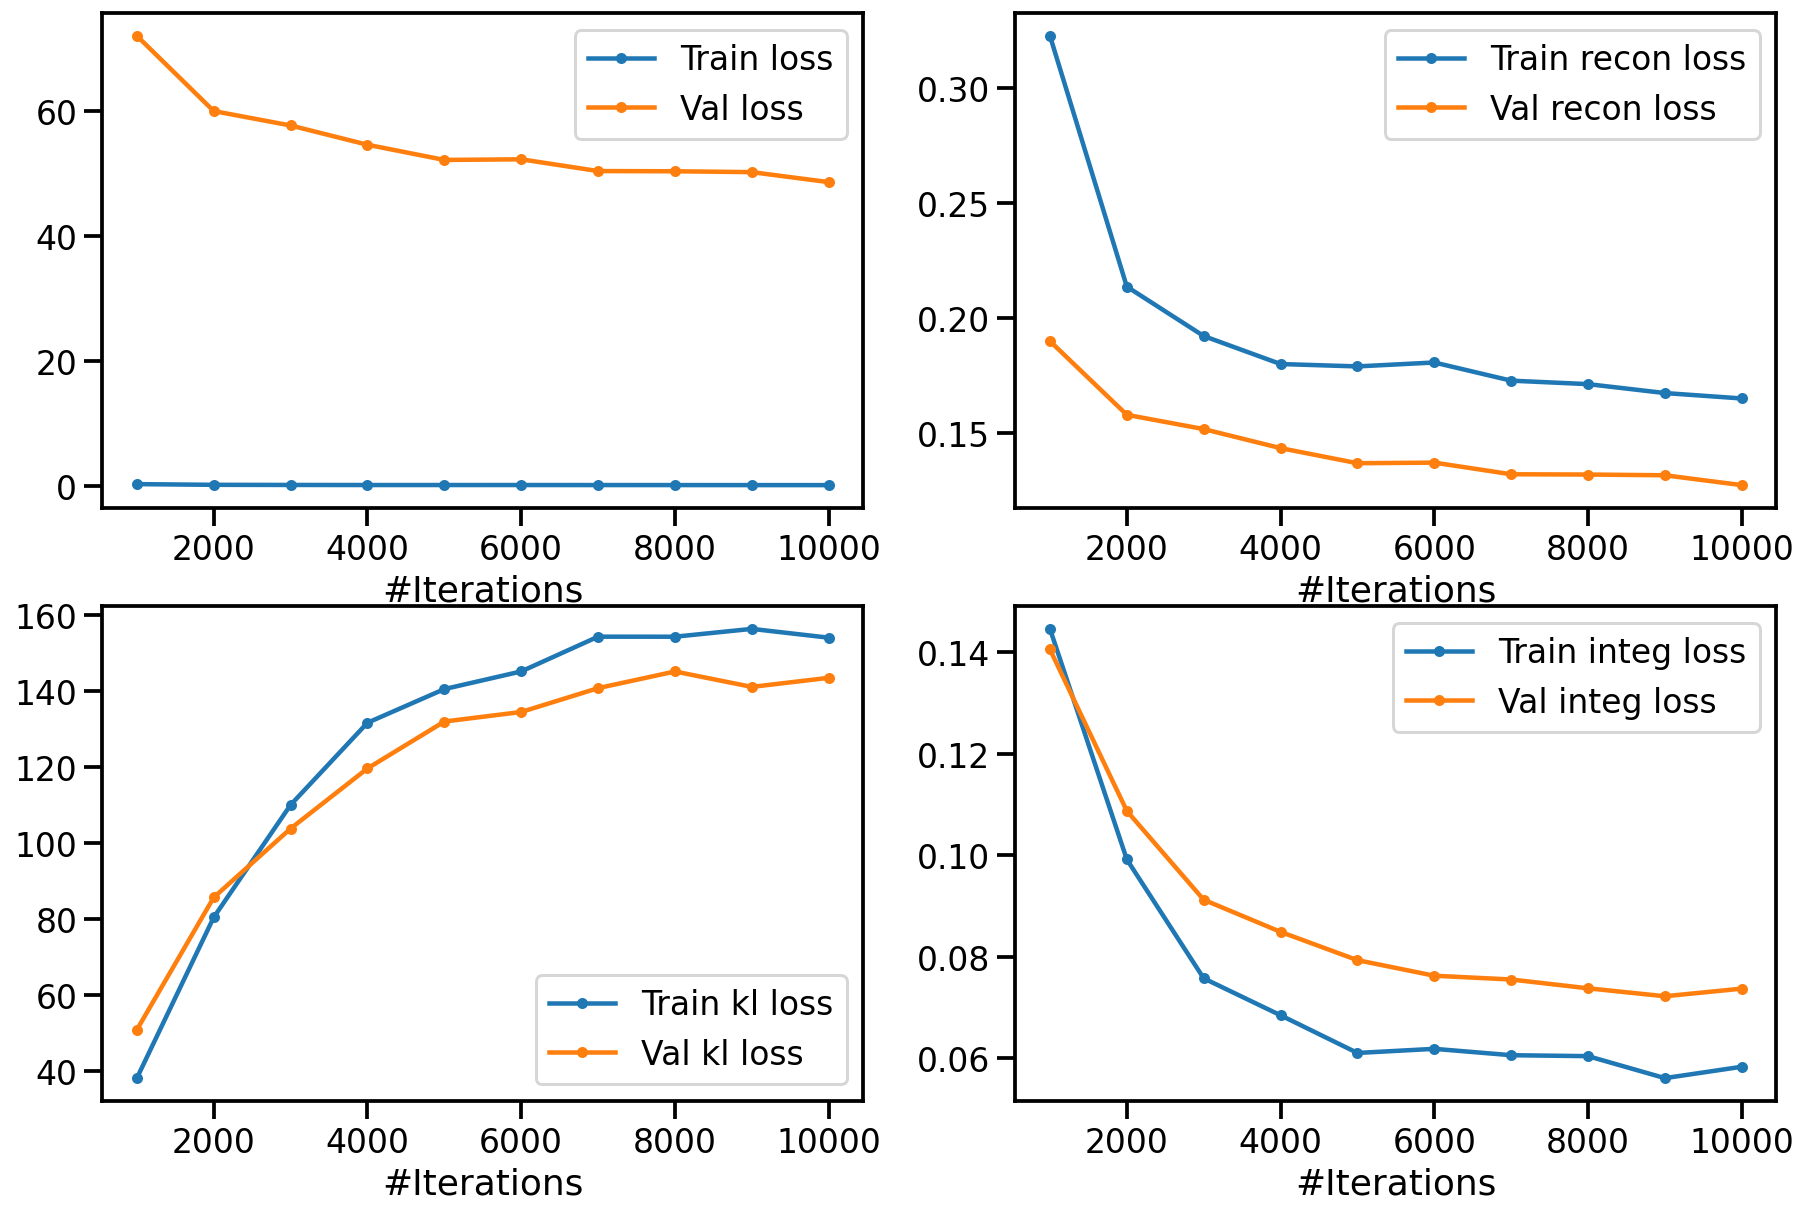

In [13]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Recover and visualize the latent space

In [15]:
z_shuffled = model.predict(
    adatas=[[scrna_shuffled], [cite_shuffled]],
    names=[['scRNA-seq'], ['scCITE-seq']],
    batch_size=64,
)
z_shuffled

AnnData object with n_obs × n_vars = 106392 × 20
    obs: 'modality', 'cell_type', 'batch'

In [16]:
sc.tl.pca(z_shuffled, svd_solver='arpack')

... storing 'modality' as categorical
... storing 'cell_type' as categorical


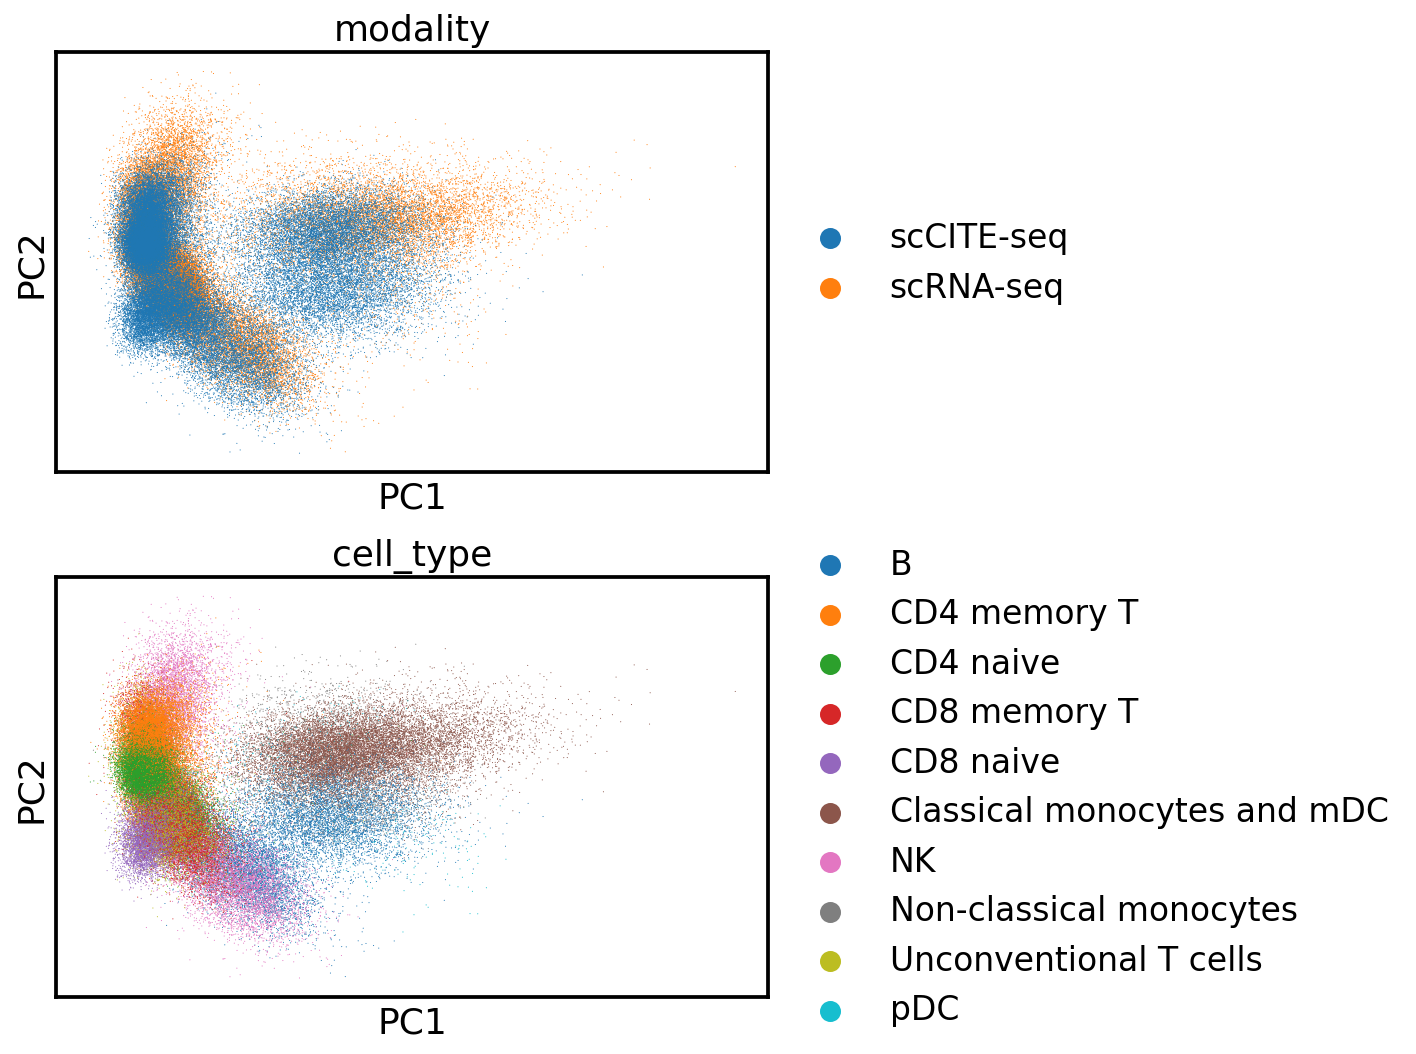

In [17]:
sc.pl.pca(z_shuffled, color=['modality', 'cell_type'], ncols = 1)

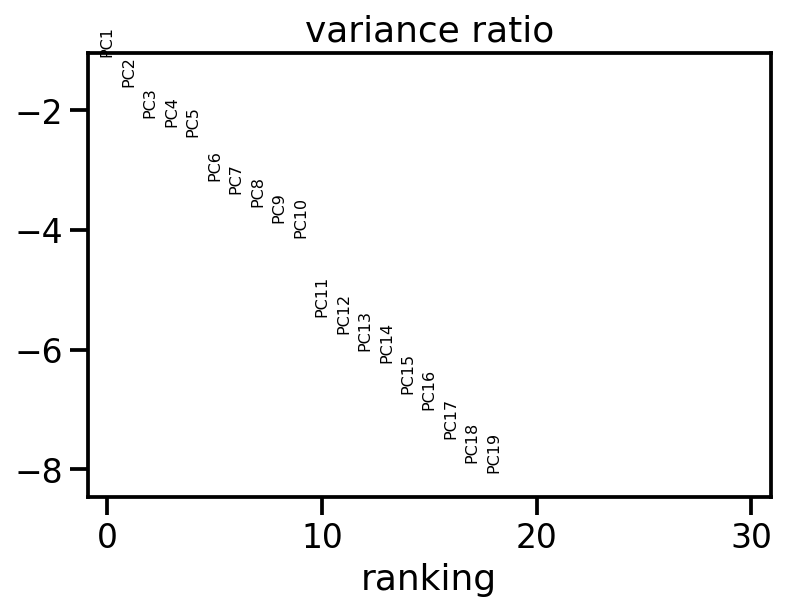

In [18]:
sc.pl.pca_variance_ratio(z_shuffled, log=True)

In [19]:
# use smaller number of neighbours than the default to make it run faster
sc.pp.neighbors(z_shuffled, n_neighbors=10, n_pcs=11)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [20]:
sc.tl.umap(z_shuffled)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


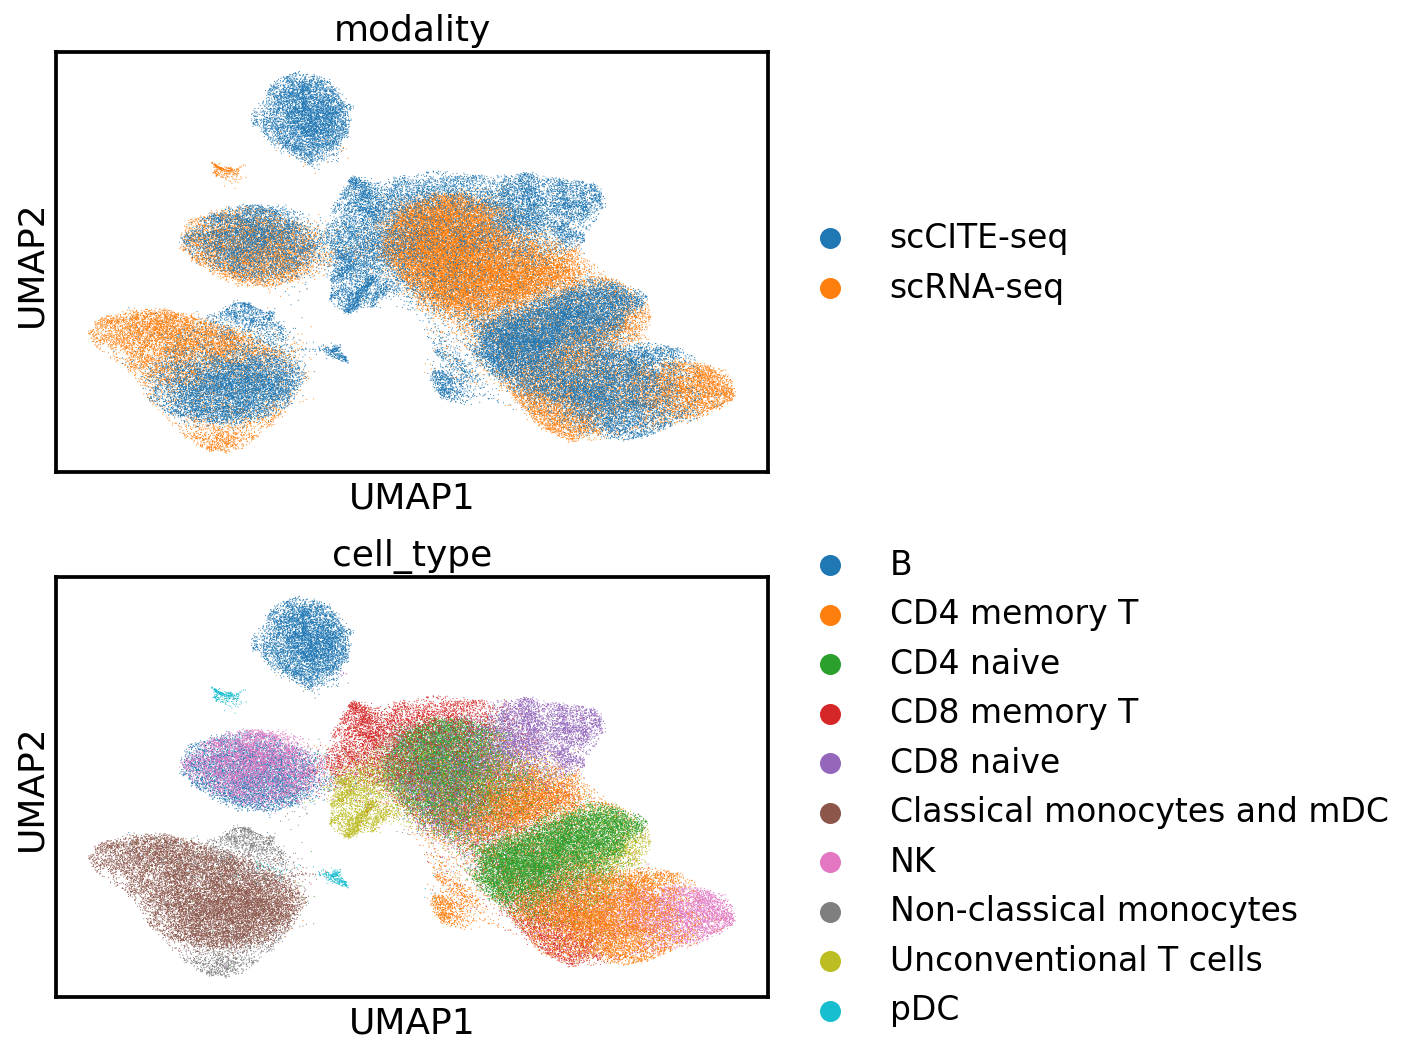

In [21]:
sc.pl.umap(z_shuffled, color=['modality', 'cell_type'], ncols=1)

## Metrics

In [22]:
scmulti.metrics.nmi(z_shuffled, label_key='modality')

0.009558941243705493

In [23]:
scmulti.metrics.asw(z_shuffled, label_key='modality')

0.0074988314881920815

In [24]:
scmulti.metrics.asw(z_shuffled, label_key='cell_type')

0.007238977588713169

In [21]:
metrics = scmulti.metrics.scibmetrics.metrics(
    z_shuffled, z_shuffled,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics

clustering...


/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_louvain.py:107: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adjacency = adata.uns['neighbors']['connectivities']
/Users/alitinet/opt

NMI...
ARI...
silhouette score...


0
NMI_cluster/label          0.473878
ARI_cluster/label          0.227214
ASW_label                  0.500844
ASW_label/batch            0.664515
PCR_batch                       NaN
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                      NaN
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN